# ResNet50 Transfer Learning Classifier — *Human* vs *Avatar* vs *Animal*

**Why ResNet50?**
- **Residual connections** make deep networks easier to optimize and reduce degradation as depth increases (the “skip‑connections” idea). This lets us use a strong feature extractor without struggling with vanishing gradients.  
- **Proven transfer learning performance**: ResNet50 pre‑trained on ImageNet provides rich, general‑purpose visual features that adapt well to small/medium custom datasets (like profile photos).  
- **Balanced accuracy vs. speed**: Compared to much larger backbones, ResNet50 is fast enough for iteration and deployment while still offering high accuracy.  
- **Fine‑tuning friendly**: We can start with the pre‑trained backbone frozen (for stability) and later unfreeze upper blocks to squeeze out extra performance.

We’ll train a 3‑class classifier for `['human', 'avatar', 'animal']` using **transfer learning + fine‑tuning**. The notebook:
1. Uses an existing split under `data/final/{train,val,test}/{human,avatar,animal}`.
2. Visualizes class distribution and sample images for each split.
3. Builds a performant `tf.data` pipeline with caching/prefetching and on‑the‑fly **data augmentation** for training only.
4. Trains a **ResNet50** backbone (frozen → optional fine‑tune), tracks metrics, and plots learning curves.
5. Evaluates on the **test set**, prints a classification report & confusion matrix.
6. Shows **24 test images** with the true label, predicted label (bold), and per‑class probabilities.

**Ethical notes & bias**: Any face‑oriented model can reflect dataset biases (e.g., demographic imbalances). Keep your dataset inclusive and evaluate performance across subgroups when possible. This pipeline supports class weighting and extensible auditing hooks to help reduce skew from label imbalance.

**References & Further Reading**
1. He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep Residual Learning for Image Recognition* (ResNet). CVPR 2016 / arXiv:1512.03385.  
   - Paper: https://arxiv.org/abs/1512.03385  
   - PDF: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf  
   - Original models (GitHub): https://github.com/KaimingHe/deep-residual-networks
2. TensorFlow / Keras ResNet50 API docs — `tf.keras.applications.ResNet50`:  
   https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50
3. TensorFlow Transfer Learning & Fine‑Tuning tutorial:  
   https://www.tensorflow.org/tutorials/images/transfer_learning
4. `tf.data` performance guide (caching, prefetch, AUTOTUNE):  
   https://www.tensorflow.org/guide/data_performance
5. Keras Applications overview (pre‑trained weights & preprocessing):  
   https://keras.io/api/applications/
6. Keras image dataset utilities (directory loading, formats):  
   https://keras.io/api/data_loading/image/

In [28]:
# %% [code] Imports & configuration
import os, math, random, json, itertools, time
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mixed precision (optional)
USE_MIXED_PRECISION = False
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")

# Paths & constants
DATA_ROOT = Path("data") / "final"   # expects train/, val/, test/ each with human/, avatar/, animal/
SPLITS = ["train", "val", "test"]
CLASS_NAMES = ['human', 'avatar', 'animal']
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 15
FINE_TUNE = False      # set True to unfreeze top layers and fine‑tune
UNFREEZE_AT = 50       # unfreeze the last N layers of the backbone when fine‑tuning

# Verify structure exists
for split in SPLITS:
    for cname in CLASS_NAMES:
        cpath = DATA_ROOT / split / cname
        assert cpath.exists() and any(cpath.glob("*")), f"Missing or empty: {cpath}"

print("Found expected directory structure under data/final")

# Notebook timing start
from datetime import datetime
RUN_START_DT = datetime.now()
RUN_START_T = time.perf_counter()


tf.get_logger().setLevel("ERROR")


# GPU memory growth
try:
    gpus = tf.config.list_physical_devices('GPU')
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass

from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

AUTOTUNE = tf.data.AUTOTUNE


Found expected directory structure under data/final


In [29]:
# %% [code] Discover files from existing splits
def find_images_split(base_split_dir: Path, class_names):
    paths, labels = [], []
    for idx, cname in enumerate(class_names):
        for p in sorted((base_split_dir / cname).rglob("*")):
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"} and p.is_file():
                paths.append(str(p))
                labels.append(idx)
    return np.array(paths), np.array(labels)

train_paths, train_labels = find_images_split(DATA_ROOT / "train", CLASS_NAMES)
val_paths,   val_labels   = find_images_split(DATA_ROOT / "val",   CLASS_NAMES)
test_paths,  test_labels  = find_images_split(DATA_ROOT / "test",  CLASS_NAMES)

print(f"Counts — train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")
for name, labels in [("train", train_labels), ("val", val_labels), ("test", test_labels)]:
    counts = Counter(labels)
    print(name, {CLASS_NAMES[i]: int(counts.get(i, 0)) for i in range(len(CLASS_NAMES))})

Counts — train: 24000, val: 3000, test: 3000
train {'human': 8000, 'avatar': 8000, 'animal': 8000}
val {'human': 1000, 'avatar': 1000, 'animal': 1000}
test {'human': 1000, 'avatar': 1000, 'animal': 1000}


In [30]:
# %% [code] Preprocessing function (fallback-safe)
# Uses existing `load_and_preprocess` or `decode_and_resize` if defined; otherwise defines a minimal one.
try:
    PREPROCESS_FN = load_and_preprocess  # already defined elsewhere
except NameError:
    try:
        PREPROCESS_FN = decode_and_resize  # already defined elsewhere
    except NameError:
        import tensorflow as tf
        def decode_and_resize(path, label):
            img = tf.io.read_file(path)
            img = tf.io.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, IMG_SIZE)  # expects IMG_SIZE=(H,W)
            # Do NOT divide by 255 here; assume model has its own Rescaling/preprocess.
            img = tf.cast(img, tf.float32)
            return img, tf.cast(label, tf.int32)
        PREPROCESS_FN = decode_and_resize

print("Using preprocessing:", PREPROCESS_FN.__name__)

Using preprocessing: decode_and_resize


In [31]:
# Memory-safe input pipeline flags
from pathlib import Path as _Path
SHUFFLE_BUFFER = min(2048, len(train_paths))  # keep shuffle memory bounded
CACHE_DATASETS = False  # set True to cache to DISK below
CACHE_DIR = _Path("cache"); CACHE_DIR.mkdir(exist_ok=True)

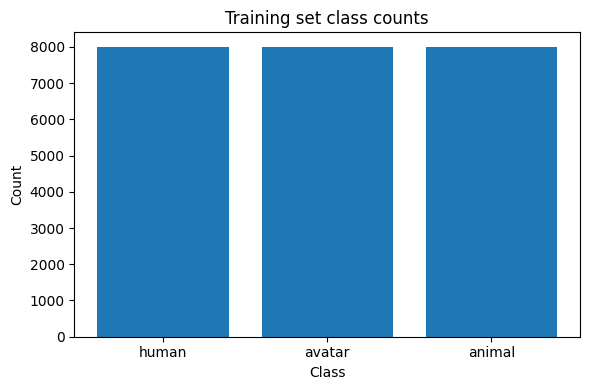

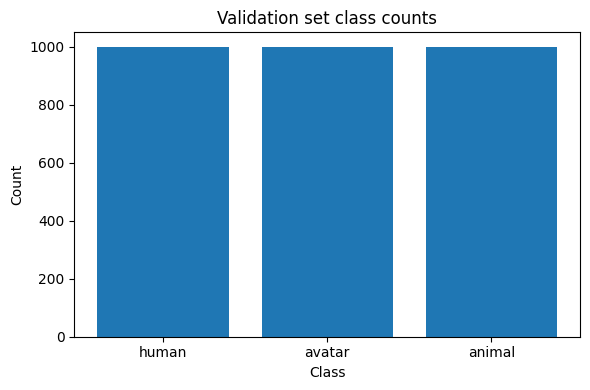

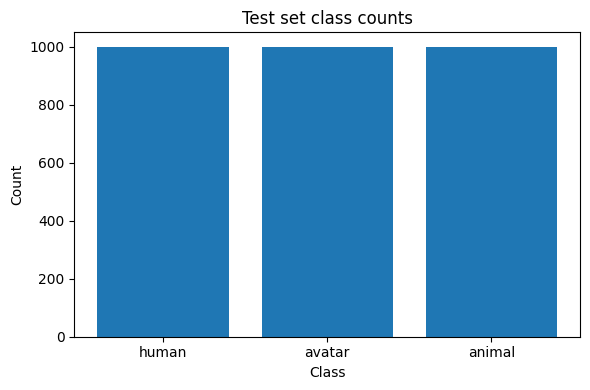

In [32]:
# %% [code] Plot class distribution for each split
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    xs = list(range(len(CLASS_NAMES)))
    ys = [counts.get(i, 0) for i in xs]
    plt.figure(figsize=(6,4))
    plt.bar([CLASS_NAMES[i] for i in xs], ys)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_labels, "Training set class counts")
plot_class_distribution(val_labels,   "Validation set class counts")
plot_class_distribution(test_labels,  "Test set class counts")

Train preview


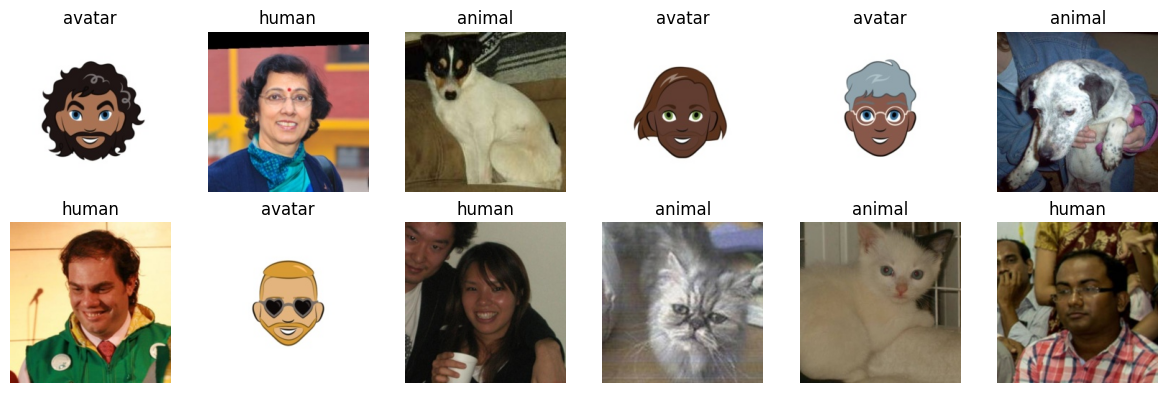

Validation preview


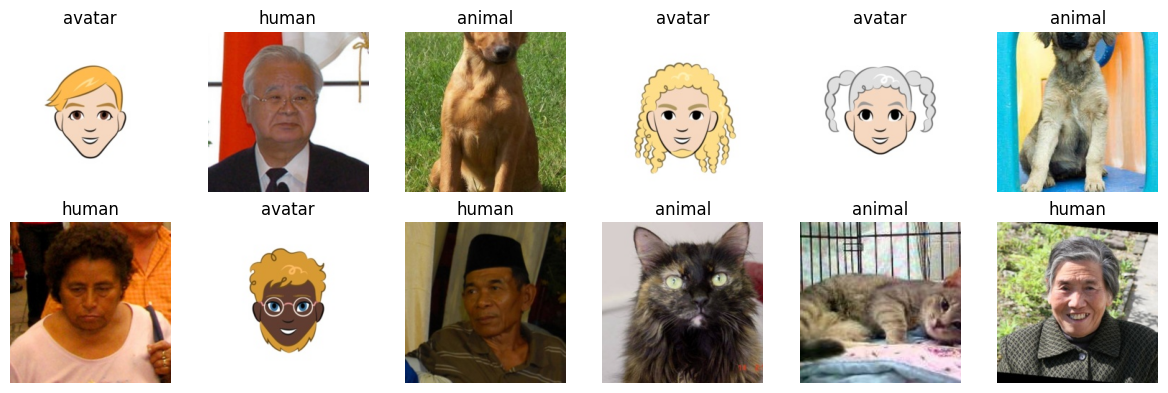

Test preview


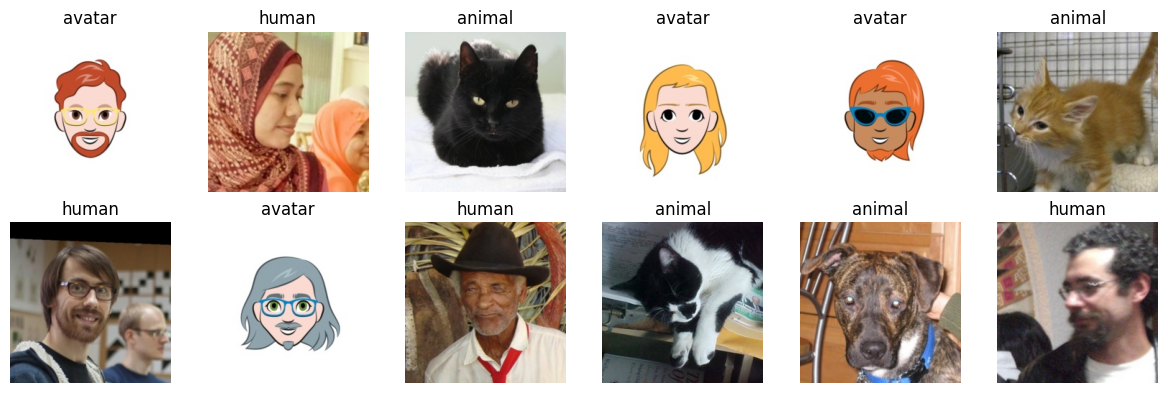

In [33]:
# %% [code] Show a few training images (memory-safe)
def show_samples(paths, labels, k=12, cols=6, seed=SEED, max_side=1024):
    '''
    Show k random samples using PIL with size guards to avoid OOM and IOPub floods.
    '''
    import math
    import numpy as np
    from PIL import Image, ImageOps

    rng = np.random.default_rng(seed)
    if len(paths) == 0:
        print("No images found.")
        return

    idxs = rng.choice(len(paths), size=min(k, len(paths)), replace=False)
    sel_paths = [paths[i] for i in idxs]
    sel_labels = [labels[i] for i in idxs]

    rows = math.ceil(len(sel_paths) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.0, rows*2.0), dpi=100)
    axes = np.array(axes).reshape(rows, cols)

    skipped = 0
    for i, (p, lab) in enumerate(zip(sel_paths, sel_labels)):
        ax = axes.flat[i]
        try:
            with Image.open(p) as im:
                im = ImageOps.exif_transpose(im.convert("RGB"))
                # Guard extremely large images
                if max(im.size) > max_side:
                    im.thumbnail((max_side, max_side), Image.BILINEAR)
                # Resize to model input size for consistency
                im = im.resize(IMG_SIZE, Image.BILINEAR)
                ax.imshow(im)
                ax.set_title(CLASS_NAMES[int(lab)])
                ax.axis("off")
        except Exception as e:
            skipped += 1
            ax.axis("off")

    # Hide any remaining axes
    for j in range(i+1, rows*cols):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()
    if skipped:
        print(f"Skipped {skipped} problematic image(s).")

print("Train preview")
show_samples(train_paths, train_labels, k=12, cols=6)
print("Validation preview")
show_samples(val_paths, val_labels, k=12, cols=6)
print("Test preview")
show_samples(test_paths, test_labels, k=12, cols=6)

In [34]:
# %% [code] Memory-safe dataset builder
def make_dataset(paths, labels, batch_size, training, split_name=None):
    import tensorflow as tf
    if split_name is None:
        split_name = 'train' if training else 'val'
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=SEED, reshuffle_each_iteration=True)
    preprocess = globals().get('load_and_preprocess', None) or globals().get('decode_and_resize', None)
    if preprocess is None:
        raise NameError("Expected a preprocessing function named 'load_and_preprocess' or 'decode_and_resize'.")
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if CACHE_DATASETS:
        ds = ds.cache(str(CACHE_DIR / f"{split_name}.cache"))
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [35]:
# %% [code] Clean memory-safe dataset pipelines (override any previous ds_*)
def build_ds(paths, labels, split_name, training):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(PREPROCESS_FN, num_parallel_calls=AUTOTUNE)
    if CACHE_DATASETS:
        ds = ds.cache(str(CACHE_DIR / f"{split_name}.cache"))
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

ds_train = build_ds(train_paths, train_labels, "train", training=True)
ds_val   = build_ds(val_paths,   val_labels,   "val",   training=False)
ds_test  = build_ds(test_paths,  test_labels,  "test",  training=False)

print("Pipelines ready:", ds_train, ds_val, ds_test)

Pipelines ready: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [36]:
# %% [code] Build the model (ResNet50 backbone + custom head)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.20),
    layers.RandomBrightness(0.20),  # TF 2.13+
], name="data_augmentation")

base = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
)

base.trainable = False  # freeze backbone for initial training

inputs = keras.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32, name="image")
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs, name="resnet50_profilepic_classifier")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "resnet50_profilepic_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                    

In [37]:
# %% [code] Compute class weights to mitigate imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(CLASS_NAMES)),
    y=train_labels
)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


In [38]:
# %% [code] Train (frozen backbone) — custom WEIGHTS checkpoint (HDF5)
class SaveBest(keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if value is None:
            return
        improved = (value < self.best) if self.mode == 'min' else (value > self.best)
        if improved:
            self.best = value
            self.model.save_weights(self.filepath)
            print(f"Saved improved weights to {self.filepath} (epoch {epoch+1}, {self.monitor}={value:.5f})")

def _jsonable_history(hdict):
    out = {}
    for k, v in hdict.items():
        try:
            out[k] = [float(x) for x in v]
        except Exception:
            out[k] = v
    return out

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    SaveBest("resnet50_best.weights.h5", monitor="val_loss", mode="min"),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

with open("history_frozen.json", "w") as f:
    import json
    json.dump(_jsonable_history(history.history), f, indent=2)

Epoch 1/15
1500/1500 [==============================] - 44s 26ms/step - loss: 0.0151 - accuracy: 0.9961 - val_loss: 0.6702 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 2/15
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.0670 - val_accuracy: 0.9743 - lr: 1.0000e-04
Epoch 3/15
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0648 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 4/15
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0932 - val_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 5/15
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.2051 - val_accuracy: 0.9373 - lr: 1.0000e-04
Epoch 6/15
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0183 - val_accuracy: 0.9937 - lr: 5.0000e-05
Epoch 7/15
1500/1500 [

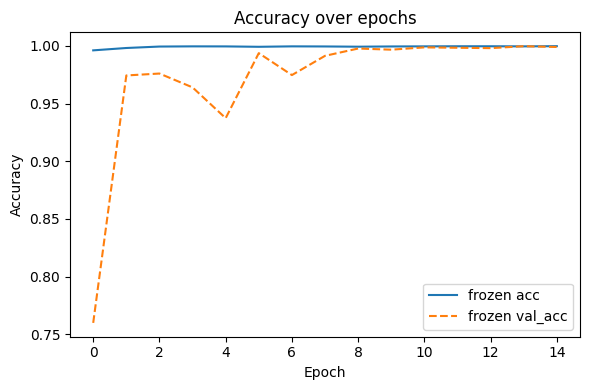

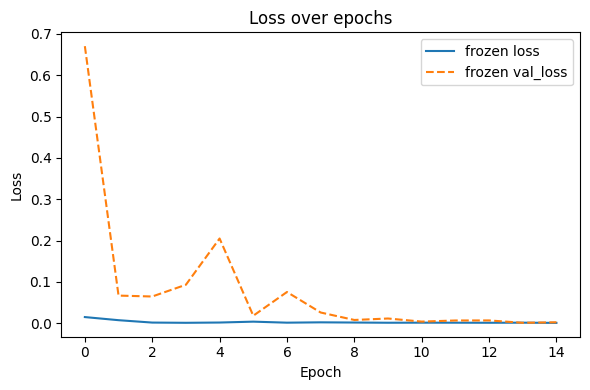

In [39]:
# %% [code] Plot learning curves
def plot_curves(histories, labels):
    plt.figure(figsize=(6,4))
    for h, lab in zip(histories, labels):
        plt.plot(h.get("accuracy", []), label=f"{lab} acc")
    for h, lab in zip(histories, labels):
        plt.plot(h.get("val_accuracy", []), linestyle="--", label=f"{lab} val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    for h, lab in zip(histories, labels):
        plt.plot(h.get("loss", []), label=f"{lab} loss")
    for h, lab in zip(histories, labels):
        plt.plot(h.get("val_loss", []), linestyle="--", label=f"{lab} val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves([history.history], ["frozen"])

In [40]:
# %% [code] Optional fine‑tuning (unfreeze last N layers) — custom WEIGHTS checkpoint
if FINE_TUNE:
    base.trainable = True
    for layer in base.layers[:-UNFREEZE_AT]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks_ft = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        SaveBest("resnet50_best_finetuned.weights.h5", monitor="val_loss", mode="min"),
    ]

    history_ft = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=max(5, EPOCHS // 2),
        class_weight=class_weights,
        callbacks=callbacks_ft,
        verbose=1
    )

    with open("history_finetune.json", "w") as f:
        import json
        json.dump(_jsonable_history(history_ft.history), f, indent=2)

    plot_curves([history.history, history_ft.history], ["frozen", "finetune"])

In [41]:
# %% [code] Evaluate on the test set
test_metrics = model.evaluate(ds_test, return_dict=True, verbose=1)
print("Test metrics:", test_metrics)

# Collect predictions and true labels
y_true = []
y_prob = []
for batch_imgs, batch_lbls in ds_test:
    probs = model.predict(batch_imgs, verbose=0)
    y_prob.append(probs)
    y_true.append(batch_lbls.numpy())

y_prob = np.concatenate(y_prob, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
print("Confusion matrix:\n", cm)

188/188 [==============================] - 3s 14ms/step - loss: 0.0028 - accuracy: 0.9987
Test metrics: {'loss': 0.0028088821563869715, 'accuracy': 0.9986666440963745}

Classification report:
              precision    recall  f1-score   support

       human     1.0000    0.9960    0.9980      1000
      avatar     1.0000    1.0000    1.0000      1000
      animal     0.9960    1.0000    0.9980      1000

    accuracy                         0.9987      3000
   macro avg     0.9987    0.9987    0.9987      3000
weighted avg     0.9987    0.9987    0.9987      3000

Confusion matrix:
 [[ 996    0    4]
 [   0 1000    0]
 [   0    0 1000]]


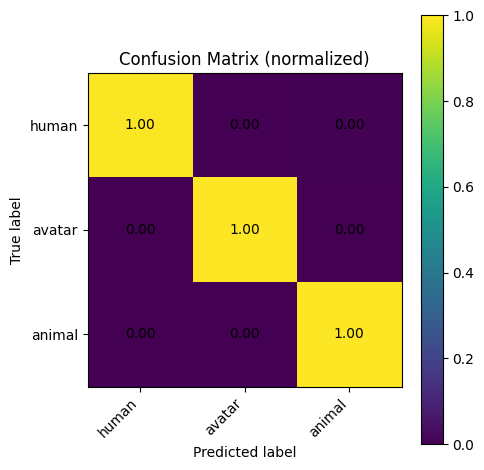

In [42]:
# %% [code] Plot confusion matrix
def plot_confusion_matrix(cm, class_names, normalize=True):
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1e-12)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion Matrix' + (' (normalized)' if normalize else ''))
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASS_NAMES, normalize=True)

Saved gallery to test_predictions_gallery.png


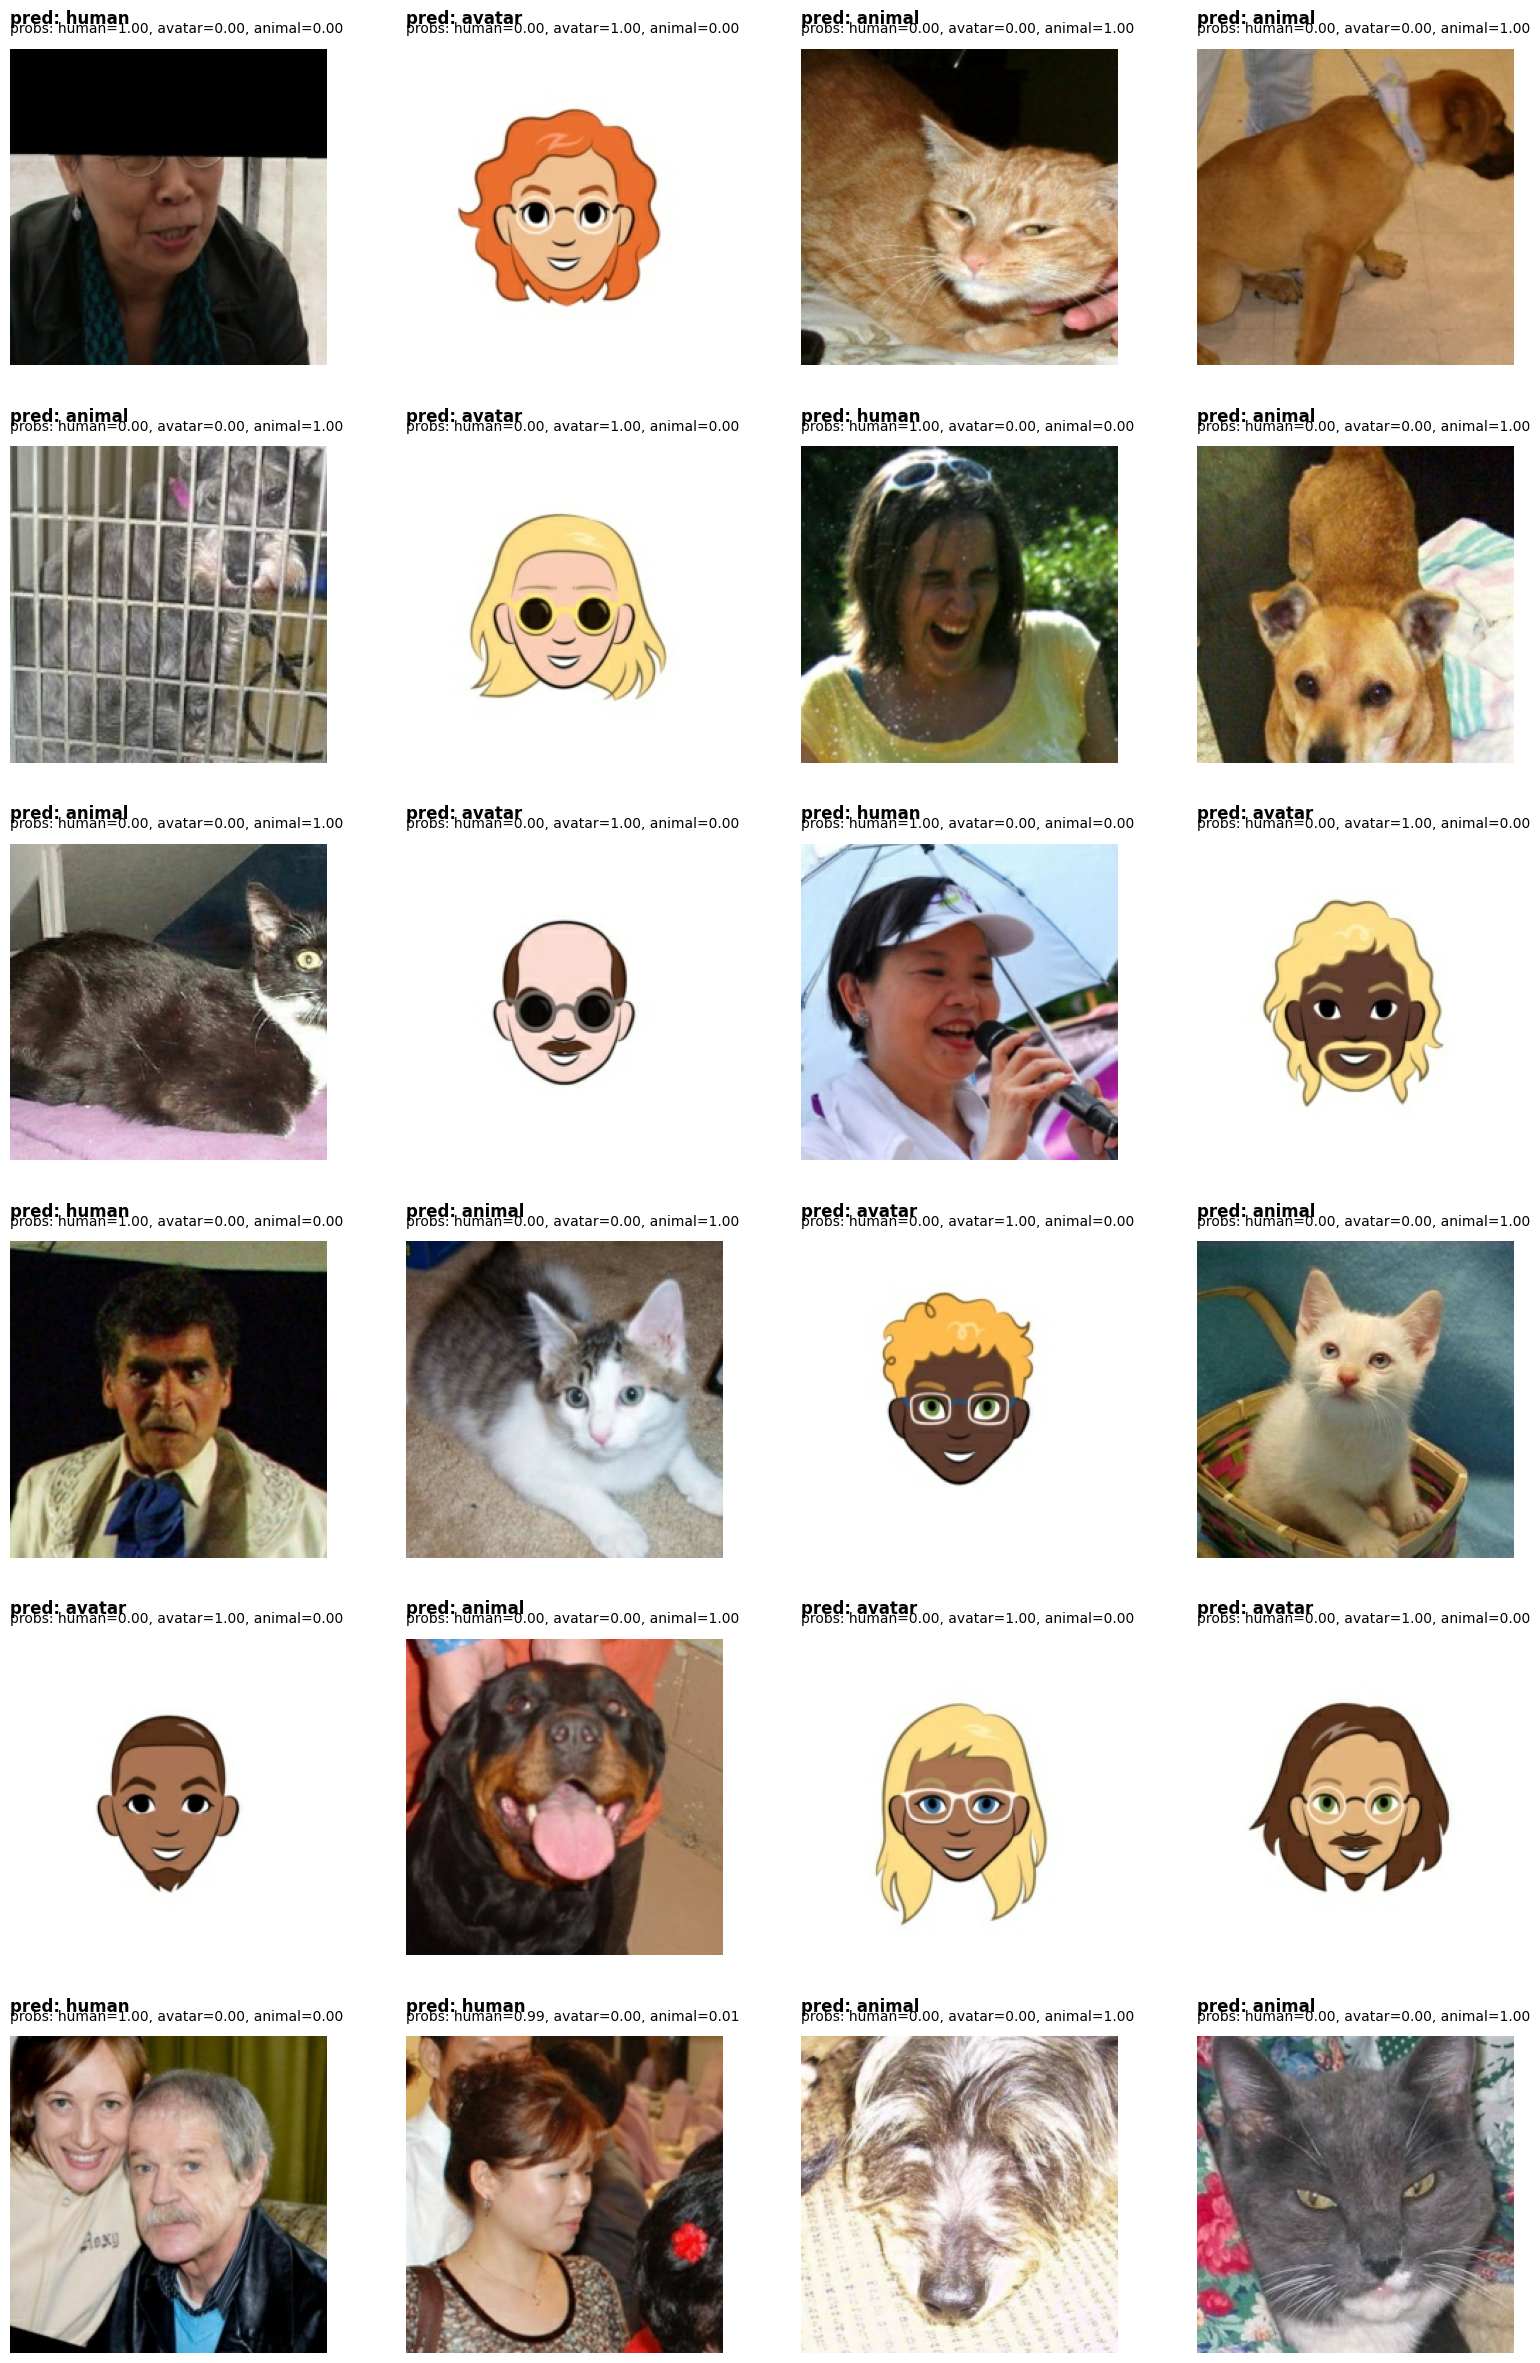

In [43]:
# %% [code] 24‑image gallery: true label, prediction (bold), class probabilities
def show_predictions_gallery(paths, labels, k=24, cols=4, save_figure="test_predictions_gallery.png"):
    rng = np.random.default_rng(SEED)
    if len(paths) == 0:
        print("No test images to display.")
        return
    idxs = rng.choice(len(paths), size=min(k, len(paths)), replace=False)
    sel_paths = paths[idxs]
    sel_labels = labels[idxs]

    imgs = []
    for p in sel_paths:
        b = tf.io.read_file(p)
        b = tf.io.decode_image(b, channels=3, expand_animations=False)
        b = tf.image.resize(b, IMG_SIZE)
        imgs.append(b.numpy())
    imgs_arr = np.stack(imgs, axis=0).astype("float32")

    pred_probs = model.predict(imgs_arr, verbose=0)
    preds = np.argmax(pred_probs, axis=1)

    rows = math.ceil(len(sel_paths) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(rows*cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.axis("off")
        if i >= len(sel_paths):
            continue

        img = imgs_arr[i].astype("uint8")
        ax.imshow(img)

        true_lab = CLASS_NAMES[sel_labels[i]]
        pred_lab = CLASS_NAMES[preds[i]]
        probs = pred_probs[i]
        lines = [
            f"true: {true_lab}",
            f"pred: {pred_lab}",
            "probs: " + ", ".join([f"{CLASS_NAMES[j]}={probs[j]:.2f}" for j in range(len(CLASS_NAMES))])
        ]
        ax.set_title(lines[0], loc="left")
        ax.set_title(lines[1], loc="left", fontweight="bold", pad=18)
        ax.text(0.0, 1.04, lines[2], transform=ax.transAxes, va="bottom", ha="left")

    plt.tight_layout()
    if save_figure:
        plt.savefig(save_figure, dpi=160, bbox_inches="tight")
        print(f"Saved gallery to {save_figure}")
    plt.show()

show_predictions_gallery(test_paths, test_labels, k=24, cols=4, save_figure="test_predictions_gallery.png")

In [44]:
# %% [code] Save final model WEIGHTS (HDF5)
model.save_weights("resnet50_profilepic_classifier.weights.h5")
print("Saved weights to resnet50_profilepic_classifier.weights.h5")

Saved weights to resnet50_profilepic_classifier.weights.h5


In [45]:
# %% [code] (Optional) How to reload weights later
# Rebuild the same architecture, then:
# model.load_weights("resnet50_profilepic_classifier.weights.h5")
# Now model is ready for inference.

In [46]:
# %% [code] Notebook runtime summary (start, end, elapsed)
from datetime import datetime
RUN_END_DT = datetime.now()
RUN_END_T = time.perf_counter()

elapsed_seconds = RUN_END_T - RUN_START_T
def _fmt_hms(seconds: float) -> str:
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds - hours*3600 - minutes*60
    return f"{hours}:{minutes:02d}:{secs:06.3f}"

print("Notebook start time:", RUN_START_DT.strftime("%Y-%m-%d %H:%M:%S"))
print("Notebook end time:  ", RUN_END_DT.strftime("%Y-%m-%d %H:%M:%S"))
print("Elapsed (H:MM:SS):  ", _fmt_hms(elapsed_seconds))

Notebook start time: 2025-08-31 16:06:28
Notebook end time:   2025-08-31 16:16:53
Elapsed (H:MM:SS):   0:10:24.355
